In [ ]:

#@title Deep Learning Project

#@markdown **VQGAN + CLIP + ESRGAN implementation**
 
#@markdown By **Siddhant Bikram Shah(2K19/CO/374) and Ayush Karn(2K19/CO/454)**

#@markdown Submitted to **Mr. Kavinder Singh**

#@markdown Original Link: https://colab.research.google.com/drive/1l7vrw6bjZWcudpafGMVKRhUDNIBEfbFn#scrollTo=gLz_LPm6qL7J

In [ ]:
#@title Checking GPU allotted by Colab
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b40242ee-09a0-1444-a7fd-4d9eb2c3aa98)


In [ ]:
#@title Cloning CLIP, VQGAN and ESRGAN 
# Installing CLIP
!git clone https://github.com/openai/CLIP                 &> /dev/null

# Installing VQGAN
!git clone https://github.com/CompVis/taming-transformers &> /dev/null

# Installing ESRGAN
!git clone https://github.com/xinntao/ESRGAN              &> /dev/null

In [ ]:
#@title Installing necessary and secondary libraries, along with ESRGAN model
# Installing necessary libraries
!pip install transformers                                 &> /dev/null
!pip install taming-transformers                          &> /dev/null
!pip install ftfy                                         &> /dev/null
!pip install regex                                        &> /dev/null
!pip isntall tqdm                                         &> /dev/null
!pip install omegaconf                                    &> /dev/null
!pip install pytorch-lightning                            &> /dev/null
!pip install kornia                                       &> /dev/null
!pip install einops                                       &> /dev/null
!pip install wget                                         &> /dev/null

# Installing secondary modules
!pip install stegano                                      &> /dev/null
!apt install exempi                                       &> /dev/null
!pip install python-xmp-toolkit                           &> /dev/null
!pip install imgtag                                       &> /dev/null
!pip install pillow==7.1.2                                &> /dev/null
!mkdir steps                                              &> /dev/null
# Downloading ESRGAN model
import gdown
gdown.download('https://drive.google.com/uc?id=1TPrz5QKd8DHHt1k8SRtm6tMiPjz_Qene', '/content/ESRGAN/models/RRDB_ESRGAN_x4.pth', quiet=True) 

'/content/ESRGAN/models/RRDB_ESRGAN_x4.pth'

In [ ]:
#@title Downloading VQGAN model trained on Imagenet
!curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' 
!curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   692  100   692    0     0   1229      0 --:--:-- --:--:-- --:--:--  1229
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  934M  100  934M    0     0  14.9M      0  0:01:02  0:01:02 --:--:-- 14.9M


In [ ]:
#@title Importing libraries and Defining functions
# Importing necessary libraries
import argparse
import math
from pathlib import Path
import sys
 
sys.path.append('./taming-transformers')
from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
 
from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
from imgtag import ImgTag    
from libxmp import *         
import libxmp                
from stegano import lsb
import json
ImageFile.LOAD_TRUNCATED_IMAGES = True

#Defining functions and classes
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
 
 
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]
 
 
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
 
 
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply
 
 
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)
 
 
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
 
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()
 
 
def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])
 
 
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            K.RandomSharpness(0.3,p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2,p=0.4),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7))
        self.noise_fac = 0.1
 
 
    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch
 
 
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        print(config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model
 
 
def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

def download_img(img_url):
    try:
        return wget.download(img_url,out="input.jpg")
    except:
        return


In [ ]:
#@title Parameter Cell: Loads the parameters
#@markdown Enter your chosen text prompt in the field below:
texts = "Snowy Mountains Sunset Pencil Sketch" #@param {type:"string"}
# Setting parameters
width =  500
height =  500
model = "vqgan_imagenet_f16_16384"
images_interval =  50
init_image = ""
target_images = ""
seed = -1
max_iterations = 500
input_images = ""

model_names={"vqgan_imagenet_f16_16384": 'ImageNet 16384',"vqgan_imagenet_f16_1024":"ImageNet 1024", 
                 "wikiart_1024":"WikiArt 1024", "wikiart_16384":"WikiArt 16384", "coco":"COCO-Stuff", "faceshq":"FacesHQ", "sflckr":"S-FLCKR", "ade20k":"ADE20K", "ffhq":"FFHQ", "celebahq":"CelebA-HQ", "gumbel_8192": "Gumbel 8192"}
name_model = model_names[model]     

if model == "gumbel_8192":
    is_gumbel = True
else:
    is_gumbel = False

if seed == -1:
    seed = None
if init_image == "None":
    init_image = None
elif init_image and init_image.lower().startswith("http"):
    init_image = download_img(init_image)


if target_images == "None" or not target_images:
    target_images = []
else:
    target_images = target_images.split("|")
    target_images = [image.strip() for image in target_images]

if init_image or target_images != []:
    input_images = True

texts = [frase.strip() for frase in texts.split("|")]
if texts == ['']:
    texts = []


args = argparse.Namespace(
    prompts=texts,
    image_prompts=target_images,
    noise_prompt_seeds=[],
    noise_prompt_weights=[],
    size=[width, height],
    init_image=init_image,
    init_weight=0.,
    clip_model='ViT-B/32',
    vqgan_config=f'{model}.yaml',
    vqgan_checkpoint=f'{model}.ckpt',
    step_size=0.0777,
    cutn=64,
    cut_pow=11.103,
    display_freq=images_interval,
    seed=seed,
)

Using device: cuda:0
Using texts: ['Snowy Mountains Sunset Pencil Sketch']
Using seed: 5327098609738268087
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 571kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 188MiB/s]


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


i: 0, loss: 0.973605, losses: 0.973605


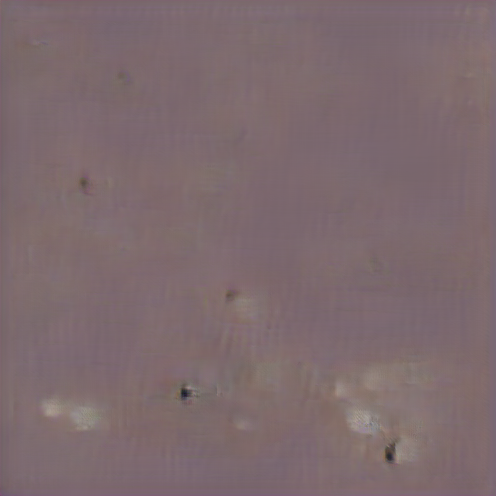

i: 50, loss: 0.817635, losses: 0.817635


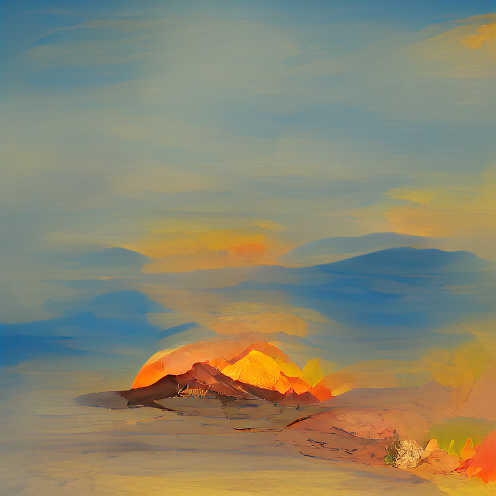

i: 100, loss: 0.686912, losses: 0.686912


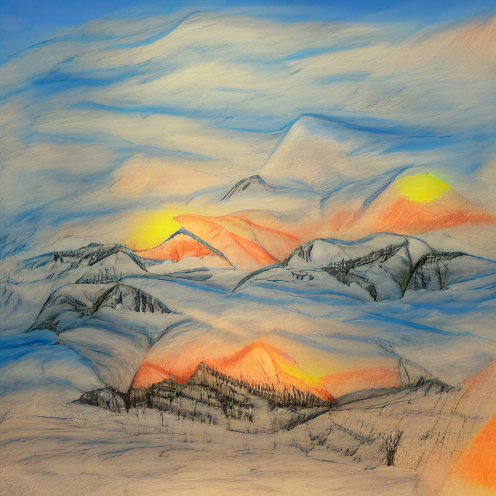

i: 150, loss: 0.663334, losses: 0.663334


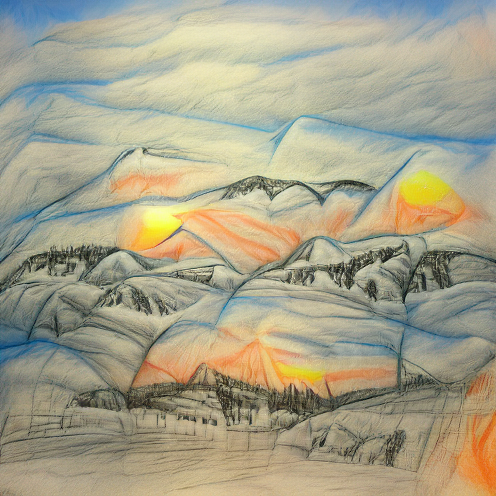

i: 200, loss: 0.650315, losses: 0.650315


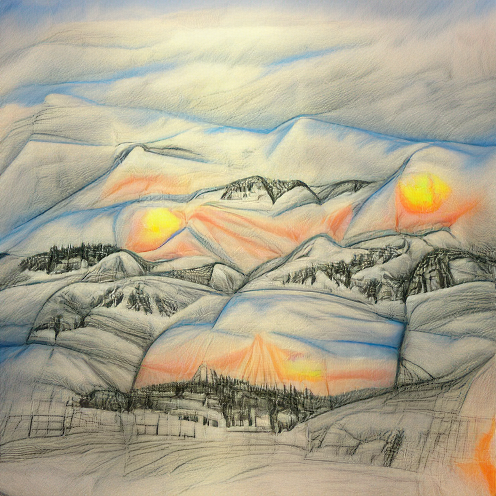

i: 250, loss: 0.652004, losses: 0.652004


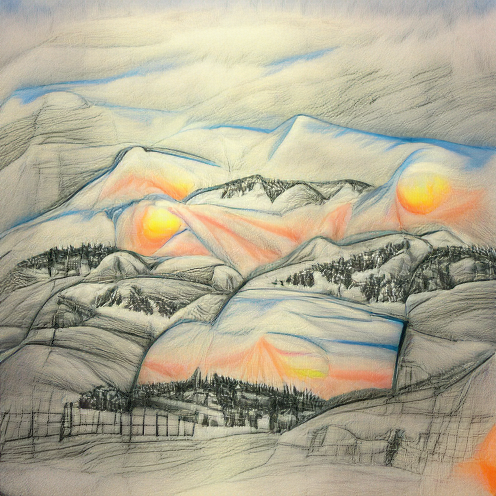

i: 300, loss: 0.645017, losses: 0.645017


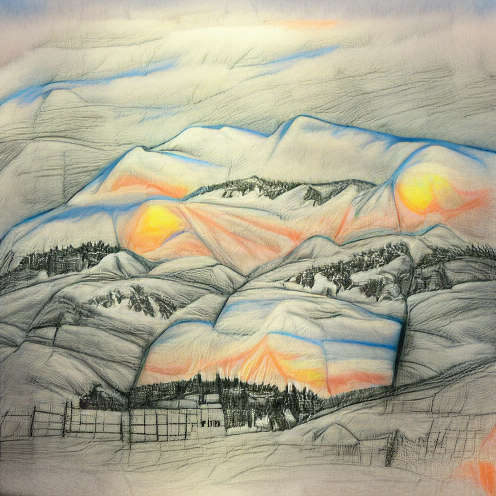

i: 350, loss: 0.640693, losses: 0.640693


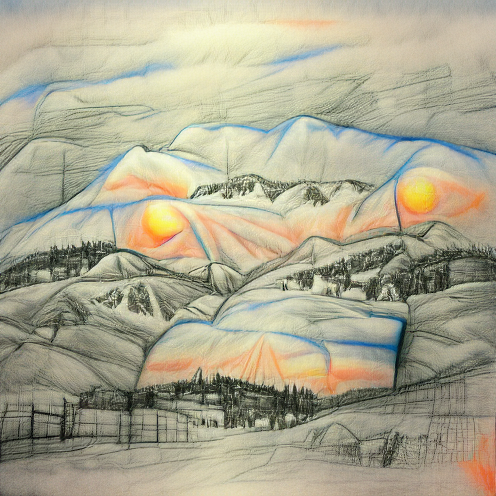

i: 400, loss: 0.640066, losses: 0.640066


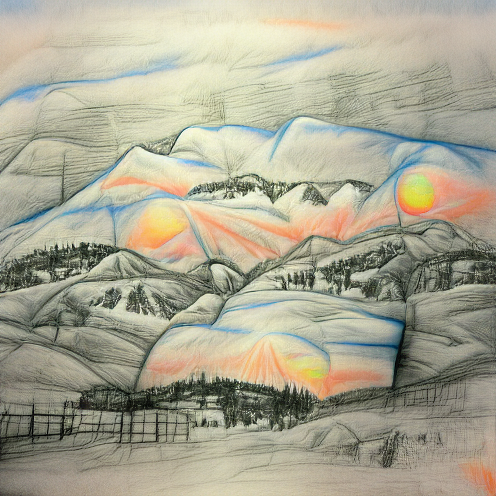

i: 450, loss: 0.635498, losses: 0.635498


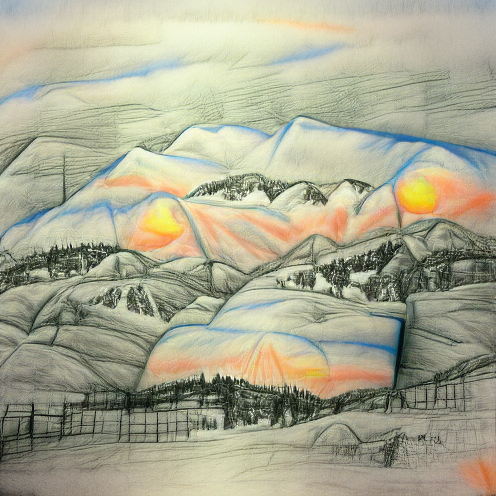

i: 500, loss: 0.634985, losses: 0.634985


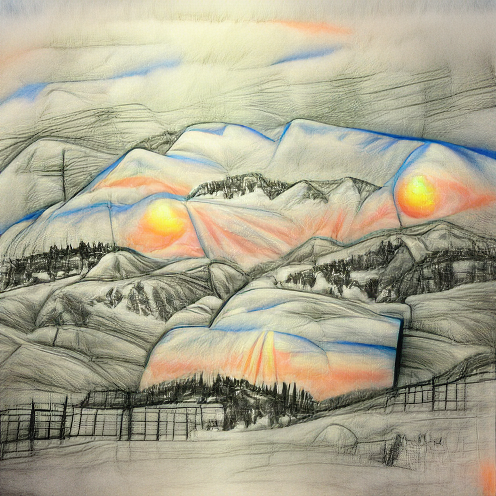

In [ ]:
#@title Running VQGAN + CLIP on our prompts. An image will be shown as output at every 50 iterations.

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if texts:
    print('Using texts:', texts)
if target_images:
    print('Using image prompts:', target_images)
if args.seed is None:
    seed = torch.seed()
else:
    seed = args.seed
torch.manual_seed(seed)
print('Using seed:', seed)

model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)

cut_size = perceptor.visual.input_resolution
if is_gumbel:
    e_dim = model.quantize.embedding_dim
else:
    e_dim = model.quantize.e_dim

f = 2**(model.decoder.num_resolutions - 1)
make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)
if is_gumbel:
    n_toks = model.quantize.n_embed
else:
    n_toks = model.quantize.n_e

toksX, toksY = args.size[0] // f, args.size[1] // f
sideX, sideY = toksX * f, toksY * f
if is_gumbel:
    z_min = model.quantize.embed.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embed.weight.max(dim=0).values[None, :, None, None]
else:
    z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

if args.init_image:
    pil_image = Image.open(args.init_image).convert('RGB')
    pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
    z, *_ = model.encode(TF.to_tensor(pil_image).to(device).unsqueeze(0) * 2 - 1)
else:
    one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
    if is_gumbel:
        z = one_hot @ model.quantize.embed.weight
    else:
        z = one_hot @ model.quantize.embedding.weight
    z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)
z_orig = z.clone()
z.requires_grad_(True)
opt = optim.Adam([z], lr=args.step_size)

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

pMs = []

for prompt in args.prompts:
    txt, weight, stop = parse_prompt(prompt)
    embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

for prompt in args.image_prompts:
    path, weight, stop = parse_prompt(prompt)
    img = resize_image(Image.open(path).convert('RGB'), (sideX, sideY))
    batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
    embed = perceptor.encode_image(normalize(batch)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
    gen = torch.Generator().manual_seed(seed)
    embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
    pMs.append(Prompt(embed, weight).to(device))

def synth(z):
    if is_gumbel:
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
    else:
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

def add_xmp_data(nombrefichero):
    imagen = ImgTag(filename=nombrefichero)
    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'creator', 'VQGAN+CLIP', {"prop_array_is_ordered":True, "prop_value_is_array":True})
    if args.prompts:
        imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', " | ".join(args.prompts), {"prop_array_is_ordered":True, "prop_value_is_array":True})
    else:
        imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', 'None', {"prop_array_is_ordered":True, "prop_value_is_array":True})
    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'i', str(i), {"prop_array_is_ordered":True, "prop_value_is_array":True})
    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'model', name_model, {"prop_array_is_ordered":True, "prop_value_is_array":True})
    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'seed',str(seed) , {"prop_array_is_ordered":True, "prop_value_is_array":True})
    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'input_images',str(input_images) , {"prop_array_is_ordered":True, "prop_value_is_array":True})
    
    imagen.close()

def add_stegano_data(filename):
    data = {
        "title": " | ".join(args.prompts) if args.prompts else None,
        "notebook": "VQGAN+CLIP",
        "i": i,
        "model": name_model,
        "seed": str(seed),
        "input_images": input_images
    }
    lsb.hide(filename, json.dumps(data)).save(filename)

@torch.no_grad()
def checkin(i, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
    out = synth(z)
    TF.to_pil_image(out[0].cpu()).save('progress.png')
    add_stegano_data('progress.png')
    add_xmp_data('progress.png')
    display.display(display.Image('progress.png'))

def ascend_txt():
    global i
    out = synth(z)
    iii = perceptor.encode_image(normalize(make_cutouts(out))).float()

    result = []

    if args.init_weight:
        result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)

    for prompt in pMs:
        result.append(prompt(iii))
    img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
    img = np.transpose(img, (1, 2, 0))
    filename = f"steps/{i:04}.png"
    imageio.imwrite(filename, np.array(img))
    add_stegano_data(filename)
    add_xmp_data(filename)
    return result

def train(i):
    opt.zero_grad()
    lossAll = ascend_txt()
    if i % args.display_freq == 0:
        checkin(i, lossAll)
    loss = sum(lossAll)
    loss.backward()
    opt.step()
    with torch.no_grad():
        z.copy_(z.maximum(z_min).minimum(z_max))

i = 0
try:
    with tqdm() as pbar:
        while True:
            train(i)
            if i == max_iterations:
                break
            i += 1
            pbar.update()
except KeyboardInterrupt:
    pass

In [ ]:
#@title Taking the 500th iteration image and copying it into ESRGAN folder
!cp content/steps/0500.png ./content/ESRGAN/LR

cp: cannot stat 'content/steps/0500.png': No such file or directory


In [ ]:
#@title Using ESRGAN to upscale our 500th iteration image. The upscaled image can be found at content/results/500.png
%cd /content/ESRGAN

import os.path as osp
import glob
import cv2
import numpy as np
import torch
import RRDBNet_arch as arch
import requests
import imageio
import requests
import warnings
warnings.filterwarnings("ignore")
from google.colab import files

Choose_device = "cuda"  

model_path = 'models/RRDB_ESRGAN_x4.pth' 
device = torch.device(Choose_device) 


test_img_folder = 'LR/*'

model = arch.RRDBNet(3, 3, 64, 23, gc=32)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
model = model.to(device)

idx = 0
for path in glob.glob(test_img_folder):
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    # read images
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img * 1.0 / 255
    img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
    img_LR = img.unsqueeze(0)
    img_LR = img_LR.to(device)

    with torch.no_grad():
        output = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
    output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
    output = (output * 255.0).round()
    cv2.imwrite('results/{:s}.png'.format(base), output)

print("Image Super Resolution Completed")

/content/ESRGAN
Image Super Resolution Completed


In [ ]:
#@title Thank you! If you have any questions, please feel free to reach out to siddhantbikramshah_2k19co374@dtu.ac.in or  ayushkarn_2k19co454@dtu.ac.in 
